# Exploring Movie Data to Provide Business Recommendations


<img src="nicole-kidman-nicole.gif" width="750" align="center">



## The Problem
### Hollywood is highly satured. How would a newcomer make movies that make money?

Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. 

Explore the data to determine what types of films are currently doing the best at the box office. Translate these findings into actionable insights a company like Microsoft can use.

## The Analysis

### Import the data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
conn = sqlite3.connect("zippedData/im.db")
import seaborn as sns

When importing from the IMDB dataset, we only want primary_title, runtime_minutes, and genres since these will be most relevant to our recommendations.

In [73]:
movie_basics = pd.read_sql("""
SELECT primary_title, runtime_minutes, genres, primary_name AS "director"
  FROM movie_basics as mb
  JOIN directors as d
    ON mb.movie_id= d.movie_id
  JOIN persons as p
    ON d.person_id = p.person_id
""", conn)
movie_gross = pd.read_csv('zippedData/tn.movie_budgets.csv', delimiter = ",")

In [74]:
movie_basics

,primary_title,runtime_minutes,genres,director
0,Sunghursh,175.0,"Action,Crime,Drama",Harnam Singh Rawail
1,Sunghursh,175.0,"Action,Crime,Drama",Harnam Singh Rawail
2,Sunghursh,175.0,"Action,Crime,Drama",Harnam Singh Rawail
3,Sunghursh,175.0,"Action,Crime,Drama",Harnam Singh Rawail
4,One Day Before the Rainy Season,114.0,"Biography,Drama",Mani Kaul
...,...,...,...,...
291166,6 Gunn,116.0,None,Kiran Gawade
291167,Chico Albuquerque - Revelações,NaN,Documentary,Vinicius Augusto Bozzo
291168,Chico Albuquerque - Revelações,NaN,Documentary,Vinicius Augusto Bozzo
291169,Chico Albuquerque - Revelações,NaN,Documentary,Angela Gurgel


### Preview the Data

Let's pull up some of the data we just imported.

In [75]:
movie_basics.head()

,primary_title,runtime_minutes,genres,director
0,Sunghursh,175.0,"Action,Crime,Drama",Harnam Singh Rawail
1,Sunghursh,175.0,"Action,Crime,Drama",Harnam Singh Rawail
2,Sunghursh,175.0,"Action,Crime,Drama",Harnam Singh Rawail
3,Sunghursh,175.0,"Action,Crime,Drama",Harnam Singh Rawail
4,One Day Before the Rainy Season,114.0,"Biography,Drama",Mani Kaul


In [76]:
movie_gross.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


### Cleaning the Data

To convert the budget and gross columns, I removed the $ and , characters and converted them to integers so we can determine profit as described above. I also want to create a column for year of release.

In [77]:
#removing the dollar signs

movie_gross["production_budget"]=movie_gross["production_budget"].str.replace('$', '')
movie_gross["domestic_gross"]=movie_gross["domestic_gross"].str.replace('$', '')
movie_gross["worldwide_gross"]=movie_gross["worldwide_gross"].str.replace('$', '')

#removing the commas
movie_gross["production_budget"]=movie_gross["production_budget"].str.replace(',', '')
movie_gross["domestic_gross"]=movie_gross["domestic_gross"].str.replace(',', '')
movie_gross["worldwide_gross"]=movie_gross["worldwide_gross"].str.replace(',', '')

#converting to intgers
movie_gross["production_budget"]=movie_gross["production_budget"].astype(int)
movie_gross["domestic_gross"] =movie_gross["domestic_gross"].astype(int)
movie_gross["worldwide_gross"]=movie_gross["worldwide_gross"].astype(int)

#creating column for year of release
movie_gross["year"] = movie_gross["release_date"].apply(lambda x:int(x[-4:]))

In [78]:
movie_gross

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,2019
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017
...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,7000,0,0,2018
5778,79,"Apr 2, 1999",Following,6000,48482,240495,1999
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,2005
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,2015


If we look at the years represented in our datasets, we see that the middle 50 is between 2000 and 2012. The set ranges between 1915 and 2019. It makes the most sense to focus on movies made between 1999 and 2020. That way we include the major clusterings in our datset and also retain validity since a movie made in the last 20 or so years has more bearing on the movies that are successful today than a movie made before then. So let's remove the rows from before 1999.

In [79]:
movie_gross["year"].describe()

count    5782.000000
mean     2003.967139
std        12.724386
min      1915.000000
25%      2000.000000
50%      2007.000000
75%      2012.000000
max      2020.000000
Name: year, dtype: float64

In [80]:
movie_gross = movie_gross.loc[movie_gross["year"] >= 1999]

I also don't want any rows where "worldwide_gross" or "domestic_gross" is $0 since those are null values and won't help me determine whether this film is profitable or not. Let's see if the number of movies that are missing both those values is the same as the ones missing just one.

In [81]:
movie_gross.loc[(movie_gross["domestic_gross"] == 0) | (movie_gross["worldwide_gross"] == 0)]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
194,95,"Dec 31, 2020",Moonfall,150000000,0,0,2020
479,80,"Dec 13, 2017",Bright,90000000,0,0,2017
480,81,"Dec 31, 2019",Army of the Dead,90000000,0,0,2019
535,36,"Feb 21, 2020",Call of the Wild,82000000,0,0,2020
617,18,"Dec 31, 2012",AstÃ©rix et ObÃ©lix: Au service de Sa MajestÃ©,77600000,0,60680125,2012
...,...,...,...,...,...,...,...
5761,62,"Dec 31, 2014",Stories of Our Lives,15000,0,0,2014
5764,65,"Dec 31, 2007",Tin Can Man,12000,0,0,2007
5771,72,"May 19, 2015",Family Motocross,10000,0,0,2015
5777,78,"Dec 31, 2018",Red 11,7000,0,0,2018


In [82]:
movie_gross.loc[(movie_gross["domestic_gross"] == 0) & (movie_gross["worldwide_gross"] == 0)]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
194,95,"Dec 31, 2020",Moonfall,150000000,0,0,2020
479,80,"Dec 13, 2017",Bright,90000000,0,0,2017
480,81,"Dec 31, 2019",Army of the Dead,90000000,0,0,2019
535,36,"Feb 21, 2020",Call of the Wild,82000000,0,0,2020
670,71,"Aug 30, 2019",PLAYMOBIL,75000000,0,0,2019
...,...,...,...,...,...,...,...
5761,62,"Dec 31, 2014",Stories of Our Lives,15000,0,0,2014
5764,65,"Dec 31, 2007",Tin Can Man,12000,0,0,2007
5771,72,"May 19, 2015",Family Motocross,10000,0,0,2015
5777,78,"Dec 31, 2018",Red 11,7000,0,0,2018


Since there are films missing one or both values for "domestic_gross" and "worldwide_gross", we're going to need to first remove all the rows that are missing both these values. Then we'll need to create two different data frames for domestic and worldwide so we don't lose important data. 

mg_clean will be our new dataframe that only contains values that have values for at least one of "domestic_gross" or "worldwide_gross."

In [83]:
mg_clean=movie_gross.loc[(movie_gross["domestic_gross"] != 0) | (movie_gross["worldwide_gross"] != 0)]

Further analysis shows that while some rows are missing domestic_gross, none are missing worldwide_gross. So mg_clean can function as our worldwide_gross dataframe, but we still need a new one for domestic.

In [84]:
mg_clean.loc[mg_clean["domestic_gross"] == 0]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
617,18,"Dec 31, 2012",AstÃ©rix et ObÃ©lix: Au service de Sa MajestÃ©,77600000,0,60680125,2012
619,20,"Jan 22, 2019",Renegades,77500000,0,1521672,2019
820,21,"Oct 26, 2018",Air Strike,65000000,0,516279,2018
1325,26,"Dec 31, 2012",Foodfight!,45000000,0,73706,2012
1367,68,"Dec 31, 2006",Les BronzÃ©s 3: amis pour la vie,42000000,0,83833602,2006
...,...,...,...,...,...,...,...
5590,91,"Mar 24, 2015",Along the Roadside,250000,0,3234,2015
5652,53,"Dec 31, 2015",Lumea e a mea,168000,0,29678,2015
5661,62,"Dec 31, 2013",Speak No Evil,150000,0,32927,2013
5705,6,"Dec 31, 2011",Absentia,70000,0,8555,2011


In [85]:
mg_clean["worldwide_gross"].value_counts().sort_index()

26            1
176           1
401           1
423           1
450           1
             ..
1518722794    1
1648854864    1
2048134200    1
2053311220    1
2776345279    1
Name: worldwide_gross, Length: 4226, dtype: int64

In [86]:
mgc_w=mg_clean.copy().drop(columns=["id", "domestic_gross"])
mgc_d=mg_clean.loc[mg_clean["domestic_gross"] > 0].drop(columns=["id", "worldwide_gross"])

In [87]:
mgc_w.head()

,release_date,movie,production_budget,worldwide_gross,year
0,"Dec 18, 2009",Avatar,425000000,2776345279,2009
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,1045663875,2011
2,"Jun 7, 2019",Dark Phoenix,350000000,149762350,2019
3,"May 1, 2015",Avengers: Age of Ultron,330600000,1403013963,2015
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,1316721747,2017


In [88]:
mgc_d.head()

,release_date,movie,production_budget,domestic_gross,year
0,"Dec 18, 2009",Avatar,425000000,760507625,2009
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,2011
2,"Jun 7, 2019",Dark Phoenix,350000000,42762350,2019
3,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,2015
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,2017


Now it's time to create new columns for profits (gross - budget), divide them by 1,000,000 to get smaller numbers, and remove the gross columns.

In [89]:
#converting to profits
mgc_w["worldwide_profits"] = mgc_w["worldwide_gross"] - mgc_w["production_budget"]
mgc_d["domestic_profits"] = mgc_d["domestic_gross"] - mgc_d["production_budget"]


#dividing by a million
mgc_w["worldprofits_inmillions"] = mgc_w["worldwide_profits"] / 1000000
mgc_d["domesticprofits_inmillions"] = mgc_d["domestic_profits"]/ 1000000

#removing gross columns
mgc_w=mgc_w.drop(columns = ["worldwide_gross", "worldwide_profits", "production_budget"])
mgc_d=mgc_d.drop(columns = ["domestic_gross", "domestic_profits", "production_budget"])

In [90]:
mgc_w

,release_date,movie,year,worldprofits_inmillions
0,"Dec 18, 2009",Avatar,2009,2351.345279
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,2011,635.063875
2,"Jun 7, 2019",Dark Phoenix,2019,-200.237650
3,"May 1, 2015",Avengers: Age of Ultron,2015,1072.413963
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,2017,999.721747
...,...,...,...,...
5775,"May 26, 2006",Cavite,2006,0.064644
5776,"Dec 31, 2004",The Mongol King,2004,-0.006100
5778,"Apr 2, 1999",Following,1999,0.234495
5779,"Jul 13, 2005",Return to the Land of Wonders,2005,-0.003662


We can see that "primary_title" in movie_basics is the same as "movie" in movie_gross. 

We're going to merge these dataframes along "primary_title" for movie_basics from IMDB and "movie" from movie_gross from The Numbers to create the new dataframe movie_totals.

In [107]:
mgcw_totals = pd.merge(mgc_w, movie_basics, left_on = "movie", right_on = "primary_title", how = "outer").dropna(subset =["worldprofits_inmillions"]).drop_duplicates().drop(columns = ["primary_title"])
mgcd_totals = pd.merge(mgc_d, movie_basics, left_on = "movie", right_on = "primary_title", how = "outer").dropna(subset =["domesticprofits_inmillions"]).drop_duplicates().drop(columns = ["primary_title"])

In [99]:
mgcw_totals.sort_values("worldprofits_inmillions")

,release_date,movie,year,worldprofits_inmillions,primary_title,runtime_minutes,genres,director
7,"Jun 7, 2019",Dark Phoenix,2019.0,-200.237650,Dark Phoenix,113.0,"Action,Adventure,Sci-Fi",Simon Kinberg
806,"Mar 11, 2011",Mars Needs Moms,2011.0,-110.450242,Mars Needs Moms,88.0,"Adventure,Animation,Family",Simon Wells
1322,"Jun 14, 2019",Men in Black: International,2019.0,-106.900000,Men in Black: International,115.0,"Action,Adventure,Comedy",F. Gary Gray
1346,"Apr 27, 2001",Town & Country,2001.0,-94.635231,NaN,NaN,NaN,NaN
1451,"Aug 16, 2002",The Adventures of Pluto Nash,2002.0,-92.905005,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
149,"Jun 12, 2015",Jurassic World,2015.0,1433.854864,Jurassic World,124.0,"Action,Adventure,Sci-Fi",Colin Trevorrow
19,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,2015.0,1747.311220,NaN,NaN,NaN,NaN
20,"Apr 27, 2018",Avengers: Infinity War,2018.0,1748.134200,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",Anthony Russo
32,"Apr 27, 2018",Avengers: Infinity War,2018.0,1748.134200,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",Joe Russo


In [100]:
mgcd_totals.sort_values("domesticprofits_inmillions")

,release_date,movie,year,domesticprofits_inmillions,primary_title,runtime_minutes,genres,director
7,"Jun 7, 2019",Dark Phoenix,2019.0,-307.237650,Dark Phoenix,113.0,"Action,Adventure,Sci-Fi",Simon Kinberg
70,"Mar 9, 2012",John Carter,2012.0,-201.941321,John Carter,132.0,"Action,Adventure,Sci-Fi",Andrew Stanton
67,"Jul 2, 2013",The Lone Ranger,2013.0,-185.697885,The Lone Ranger,150.0,"Action,Adventure,Western",Gore Verbinski
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,2011.0,-169.536125,Pirates of the Caribbean: On Stranger Tides,136.0,"Action,Adventure,Fantasy",Rob Marshall
143,"May 18, 2012",Battleship,2012.0,-154.766600,Battleship,131.0,"Action,Adventure,Sci-Fi",Peter Berg
...,...,...,...,...,...,...,...,...
130,"May 4, 2012",The Avengers,2012.0,398.279547,The Avengers,143.0,"Action,Adventure,Sci-Fi",Joss Whedon
185,"Jun 15, 2018",Incredibles 2,2018.0,408.581744,Incredibles 2,118.0,"Action,Adventure,Animation",Brad Bird
149,"Jun 12, 2015",Jurassic World,2015.0,437.270625,Jurassic World,124.0,"Action,Adventure,Sci-Fi",Colin Trevorrow
181,"Feb 16, 2018",Black Panther,2018.0,500.059566,Black Panther,134.0,"Action,Adventure,Sci-Fi",Ryan Coogler


Now we have a clean pair of dataframes that tell us release date, movie, year of release, profits, runtime, genres, and director for both worldwide profits and domestic profits. We are missing some values in "primary_title," "runtime_minutes," and "genres," but we'll need to remove these later as needed. It's time to move on to the analysis.

# The Analysis
## When should Microsoft release movies?

Movies are released at key points throughout the year – the summer blockbuster, the Christmas flick. The time of year a movie is released might be critical to its profitability.

I start by creating new dataframes that include month columns which add a month number based on the "release_date" column. I then remove unneded columns and group each dataframe by the average profits.

In [109]:
#adding a months column for our worldwide dataframe and removing unneded column
month_w = mgc_w.copy()
month_w['month']=pd.to_datetime(month_w['release_date']).dt.month
month_w=month_w.drop(columns=["release_date", "movie", "year"])
month_w=month_w.groupby("month").mean().reset_index()

#adding a months column for our domestic dataframe and removing "release_date" column
month_d = mgc_d.copy()
month_d['month']=pd.to_datetime(month_d['release_date']).dt.month
month_d=month_d.drop(columns=["release_date", "movie", "year"])
month_d=month_d.groupby("month").mean().reset_index()

Now we can map the relationship between month of release and profits. The first visualization includes both worldwide (pink) and domestic (green). The second visualization allows us to see jsut domestic profits since worldwide profits dwarfs them.

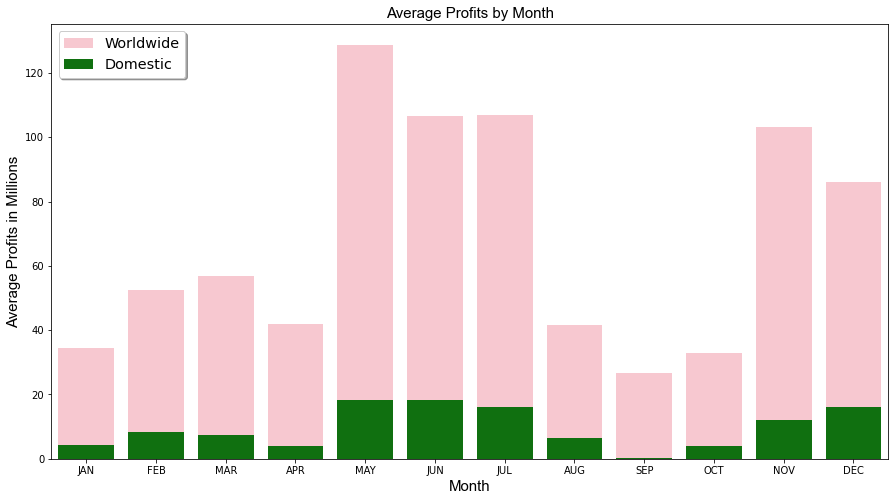

In [110]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=month_w["month"], y=month_w["worldprofits_inmillions"], color='pink', label='Worldwide', ci = None)
ax = sns.barplot(x=month_d["month"], y=month_d["domesticprofits_inmillions"], color='green', label= 'Domestic', ci = None)
ax.set_xlabel('Month', fontfamily = 'Arial', fontsize = 15)
ax.set_ylabel('Average Profits in Millions', fontfamily = 'Arial', fontsize = 15)
ax.set_title('Average Profits by Month', fontfamily = 'Arial', fontsize = 15)
ax.set_xticklabels(['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'])
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

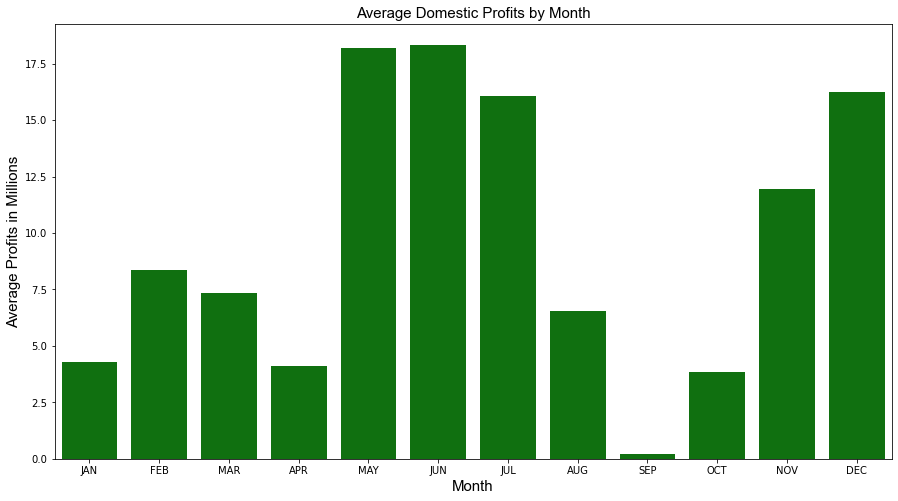

In [111]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=month_d["month"], y=month_d["domesticprofits_inmillions"], color='green', label= 'Domestic', ci = None)
ax.set_xlabel('Month', fontfamily = 'Arial', fontsize = 15)
ax.set_ylabel('Average Profits in Millions', fontfamily = 'Arial', fontsize = 15)
ax.set_title('Average Domestic Profits by Month', fontfamily = 'Arial', fontsize = 15)
ax.set_xticklabels(['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']);

#### For both world and domestic releases, it makes sense for Microsoft to release its movies in May, June, and July. 

#### November and December are also good months to release movies. 

#### September is the worst month for a movie release.

## What genres should Microsoft focus on?

There are so many types of films a studio can make. From action to musical, there are so many options and combinations of genres that can yield profits. Which genres are the most profitable?

To get genre information, we need to go back to mgcw_totals and mgcd_totals dataframes. Let's remove all rows where genre isn't listed.

In [112]:
mgcw_totals

,release_date,movie,year,worldprofits_inmillions,runtime_minutes,genres,director
0,"Dec 18, 2009",Avatar,2009.0,2351.345279,93.0,Horror,Atsushi Wada
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,2011.0,635.063875,136.0,"Action,Adventure,Fantasy",Rob Marshall
7,"Jun 7, 2019",Dark Phoenix,2019.0,-200.237650,113.0,"Action,Adventure,Sci-Fi",Simon Kinberg
13,"May 1, 2015",Avengers: Age of Ultron,2015.0,1072.413963,141.0,"Action,Adventure,Sci-Fi",Joss Whedon
18,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,2017.0,999.721747,NaN,NaN,NaN
...,...,...,...,...,...,...,...
9836,"May 26, 2006",Cavite,2006.0,0.064644,NaN,NaN,NaN
9837,"Dec 31, 2004",The Mongol King,2004.0,-0.006100,NaN,NaN,NaN
9838,"Apr 2, 1999",Following,1999.0,0.234495,NaN,NaN,NaN
9839,"Jul 13, 2005",Return to the Land of Wonders,2005.0,-0.003662,NaN,NaN,NaN


In [113]:
genres_w = mgcw_totals.dropna(subset=["genres"]).drop(columns=["release_date", "movie", "year", "runtime_minutes", "director"])
genres_d = mgcd_totals.dropna(subset=["genres"]).drop(columns=["release_date", "movie", "year", "runtime_minutes", "director"])

In some cases, our genres are clustered together. Let's separate them.

In [114]:
genres_w["genres"] = genres_w["genres"].apply(lambda x: str(x).split(","))
genres_w = genres_w.explode('genres')
genres_w=genres_w.groupby("genres").mean().reset_index()
genres_d["genres"] = genres_d["genres"].apply(lambda x: str(x).split(","))
genres_d = genres_d.explode('genres')
genres_d=genres_d.groupby("genres").mean().reset_index()

In [115]:
genres_w

,genres,worldprofits_inmillions
0,Action,134.665054
1,Adventure,229.052301
2,Animation,274.495645
3,Biography,45.428056
4,Comedy,92.263837
5,Crime,43.854648
6,Documentary,45.756058
7,Drama,39.496582
8,Family,110.582987
9,Fantasy,152.370243


Now we can map the relationship between genre and profits. The first visualization maps worldwide profits against genre, the second domestic profits against genre, and the third both against genre.

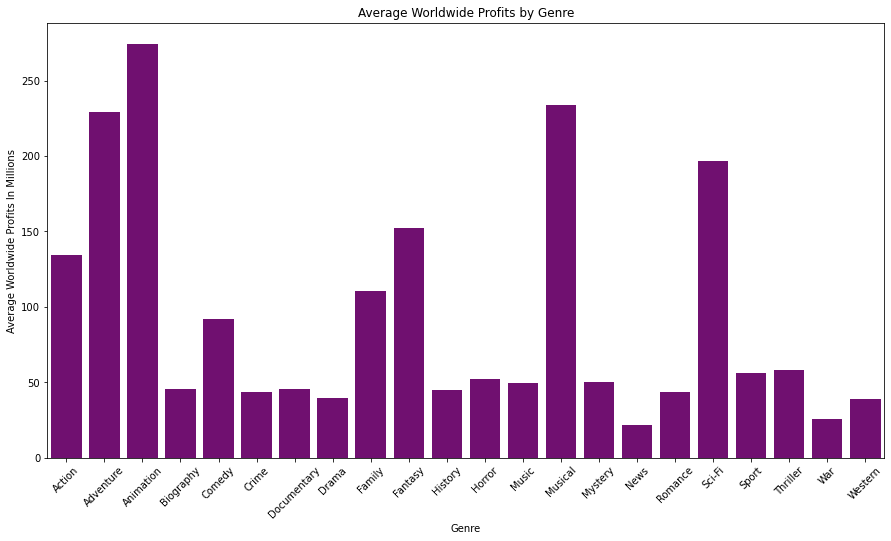

In [116]:
plt.figure(figsize=(15,8))
w = sns.barplot(data=genres_w, x="genres", y="worldprofits_inmillions", color = "purple", ci=None)
w.set(xlabel='Genre',
       ylabel='Average Worldwide Profits In Millions',
       title='Average Worldwide Profits by Genre')
plt.xticks(rotation=45)

plt.show()

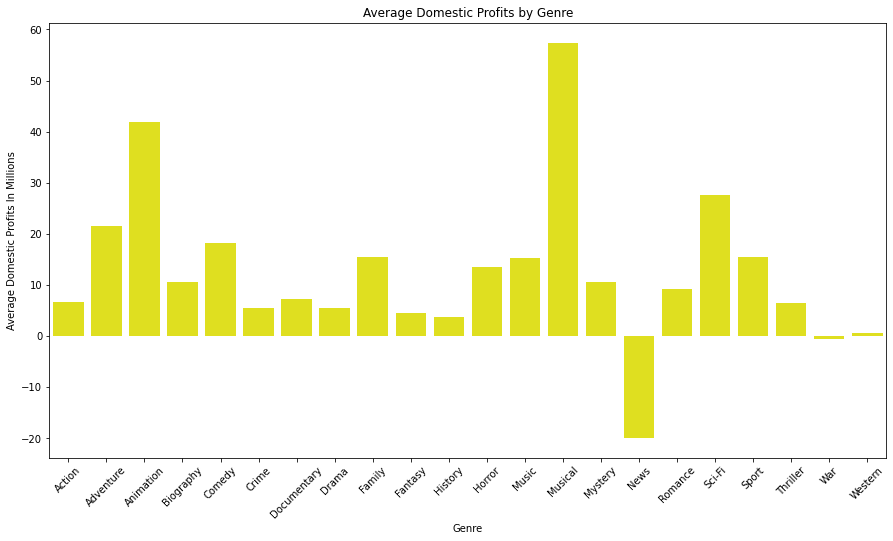

In [117]:
plt.figure(figsize=(15,8))
v = sns.barplot(data=genres_d, x="genres", y="domesticprofits_inmillions", color = "yellow", ci=None)
v.set(xlabel='Genre',
       ylabel='Average Domestic Profits In Millions',
       title='Average Domestic Profits by Genre')
plt.xticks(rotation=45)

plt.show()

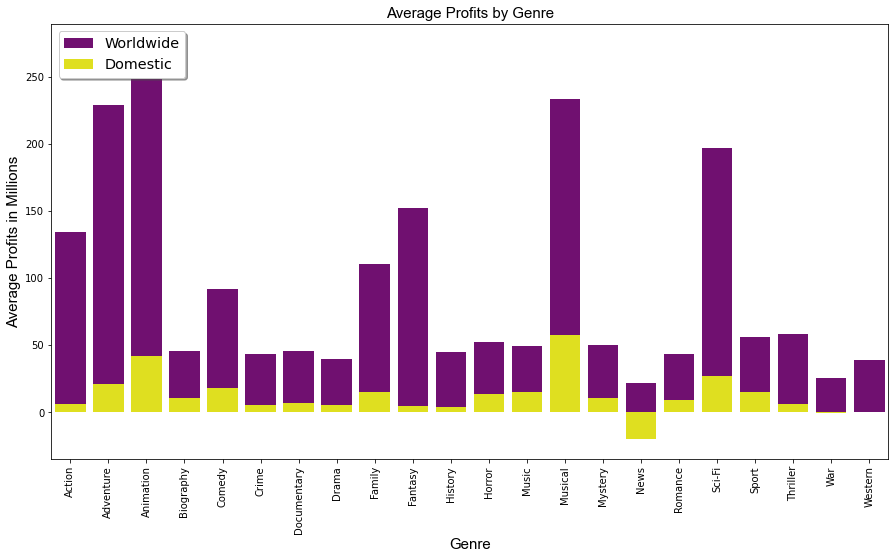

In [118]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=genres_w["genres"], y=genres_w["worldprofits_inmillions"], color='purple', label='Worldwide', ci = None)
ax = sns.barplot(x=genres_d["genres"], y=genres_d["domesticprofits_inmillions"], color='yellow', label= 'Domestic', ci = None)
ax.set_xlabel('Genre', fontfamily = 'Arial', fontsize = 15)
ax.set_ylabel('Average Profits in Millions', fontfamily = 'Arial', fontsize = 15)
ax.set_title('Average Profits by Genre', fontfamily = 'Arial', fontsize = 15)
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xticks(rotation=90);

But since genres were clustered in our dataset originally, we don't want to lose data in separating them and only offering suggestions based on that finding. Below are the top clustered genres for worldwide and domestic releases.

In [120]:
world_clusters = mgcw_totals.dropna(subset=["genres"]).drop(columns = ["release_date", "movie", "year",
                                                                      "runtime_minutes", "director"])
world_clusters = world_clusters.groupby("genres").mean().reset_index()
world_clusters.sort_values(by = "worldprofits_inmillions", ascending=False).head(20)

,genres,worldprofits_inmillions
299,"Fantasy,Romance",1122.469910
107,"Adventure,Drama,Sport",1122.469910
291,"Family,Fantasy,Musical",1099.199706
298,"Fantasy,Musical",825.491110
106,"Adventure,Drama,Sci-Fi",524.325409
14,"Action,Adventure,Sci-Fi",497.186715
113,"Adventure,Fantasy",469.544026
240,"Drama,Family,Fantasy",439.551353
236,"Documentary,Thriller",354.683805
123,"Animation,Comedy,Family",348.231114


In [121]:
domestic_clusters = mgcd_totals.dropna(subset=["genres"]).drop(columns = ["release_date", "movie", "year",
                                                                      "runtime_minutes", "director"])
domestic_clusters = domestic_clusters.groupby("genres").mean().reset_index()
domestic_clusters.sort_values(by = "domesticprofits_inmillions", ascending=False).head(20)

,genres,domesticprofits_inmillions
283,"Family,Fantasy,Musical",344.014165
291,"Fantasy,Romance",250.738009
105,"Adventure,Drama,Sport",250.738009
107,"Adventure,Drama,Western",136.243005
290,"Fantasy,Musical",134.191110
119,"Animation,Comedy,Family",129.283858
190,"Comedy,Romance,Sci-Fi",117.805123
233,"Drama,Family,Fantasy",106.151353
217,"Documentary,Drama,Sport",102.153342
25,"Action,Comedy,Documentary",97.229692


#### Based on the visualizations, adventure, animation, musical, and sci-fi are all top genres for worldwide releases. While musical, animation, and sci-fi are top for domestic releases.

#### If we focused on clusters, by contrast, we're going to want some combination of adventure, drama, sport, fantasy, romance, musical, and/or family for world releases and all the same in addition to western for domestic releases. This is interesting because western films on the whole seem to result in losses in the domestic market.


## How long should Microsoft's Movies Be?

Movies range in time. Short, 90 minute films are great for kids and family films while Marvel releases tend to be two hours or longer. What's the sweet spot to maximize profits?

Going back to our mgcw_totals and mgcd_totals dataframes, we can hone in on runtime with "runtime_minutes."

In [123]:
runtimes_w = mgcw_totals.drop(columns=["release_date", "movie", "year", "genres", "director"]).dropna()
runtimes_d = mgcd_totals.drop(columns=["release_date", "movie", "year", "genres", "director"]).dropna()
runtimes_w.describe()

,worldprofits_inmillions,runtime_minutes
count,2981.000000,2981.000000
mean,79.079858,98.445824
std,181.841336,26.673998
min,-200.237650,1.000000
25%,-2.096670,88.000000
50%,13.945682,99.000000
75%,71.519217,112.000000
max,2351.345279,360.000000


In [124]:
runtimes_d

,domesticprofits_inmillions,runtime_minutes
0,335.507625,93.0
2,-169.536125,136.0
7,-307.237650,113.0
13,128.405868,141.0
20,378.815482,149.0
...,...,...
9361,-0.023453,83.0
9363,-0.023453,26.0
9369,0.128711,70.0
9370,0.084596,93.0


The middle 50 of our data is 88 minutes to 113 minutes runtime. The minimum runtime is 1 minute and the maximum is 3 hours. We'll focus on movies between 80 and 150 minutes to hone in on where the average movie might fall while also keeping in the trend towards 2.5 hour long films.

In [125]:
runtimes_w = runtimes_w.loc[(runtimes_w["runtime_minutes"] >= 80) & (runtimes_w["runtime_minutes"] <= 150)]
runtimes_w = runtimes_w.groupby("runtime_minutes").mean().reset_index()
runtimes_d = runtimes_d.loc[(runtimes_d["runtime_minutes"] >= 80) & (runtimes_d["runtime_minutes"] <= 150)]
runtimes_d = runtimes_d.groupby("runtime_minutes").mean().reset_index()

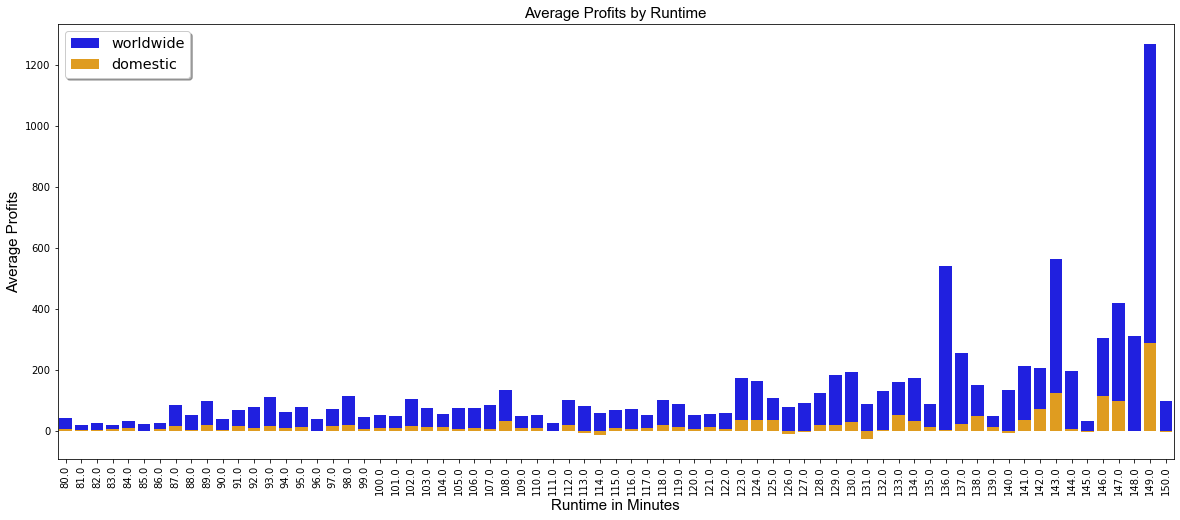

In [126]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x=runtimes_w["runtime_minutes"], y=runtimes_w["worldprofits_inmillions"], 
                 label = "worldwide", color = "blue", ci=None)
ax = sns.barplot(x=runtimes_d["runtime_minutes"], y=runtimes_d["domesticprofits_inmillions"], 
                               label = "domestic", color = "orange", ci=None)
ax.set_xlabel('Runtime in Minutes', fontfamily = 'Arial', fontsize = 15)
ax.set_ylabel('Average Profits', fontfamily = 'Arial', fontsize = 15)
ax.set_title('Average Profits by Runtime', fontfamily = 'Arial', fontsize = 15)
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xticks(rotation=90)
plt.show()

The above visualization shows that most of the profits in our range are closer to 150, so let's redo the graph looking at that section.

In [128]:
runtimeslong_w = runtimes_w.loc[(runtimes_w["runtime_minutes"] >= 120) & (runtimes_w["runtime_minutes"] <= 150)]
runtimeslong_w = runtimeslong_w.groupby("runtime_minutes").mean().reset_index()
runtimeslong_d = runtimes_d.loc[(runtimes_d["runtime_minutes"] >= 120) & (runtimes_d["runtime_minutes"] <= 150)]
runtimeslong_d = runtimeslong_d.groupby("runtime_minutes").mean().reset_index()

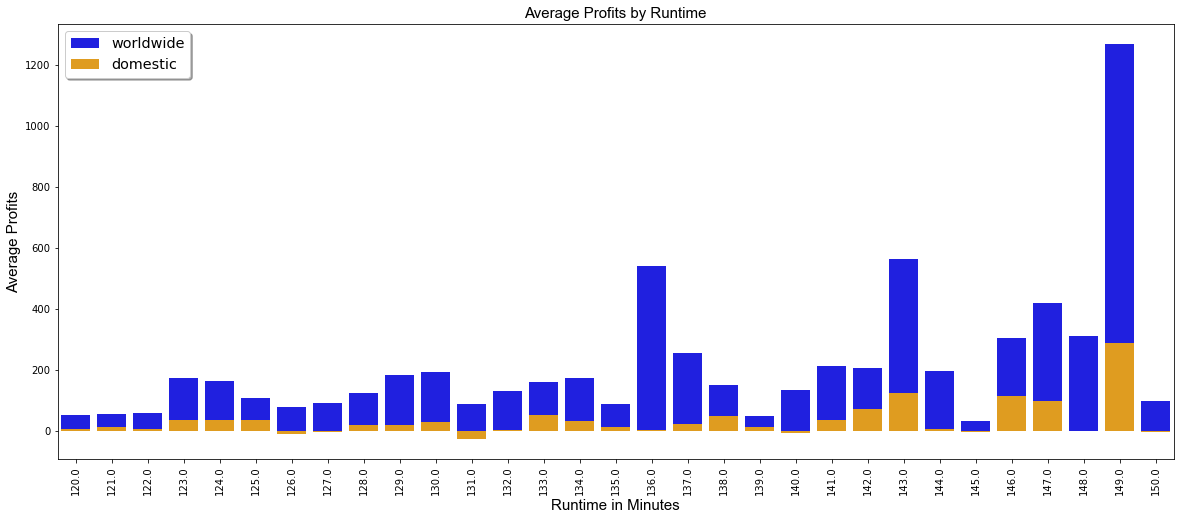

In [129]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x=runtimeslong_w["runtime_minutes"], y=runtimeslong_w["worldprofits_inmillions"], 
                 label = "worldwide", color = "blue", ci=None)
ax = sns.barplot(x=runtimeslong_d["runtime_minutes"], y=runtimeslong_d["domesticprofits_inmillions"], 
                               label = "domestic", color = "orange", ci=None)
ax.set_xlabel('Runtime in Minutes', fontfamily = 'Arial', fontsize = 15)
ax.set_ylabel('Average Profits', fontfamily = 'Arial', fontsize = 15)
ax.set_title('Average Profits by Runtime', fontfamily = 'Arial', fontsize = 15)
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xticks(rotation=90)
plt.show()

### For worldwide releases, the most profitable runtime is 149 minutes, followed by 143 and 136 minutes. For domestic releases, the best times are 149 minutes, 143 and 146 minutes.

These are all over 2 hours, indicating a trend towards longer movies overall. Microsoft should aim for a movie that runs for 149 minutes to maximize profits.

## Which director should Microsoft hire to make their movies?

A good film comes down to story, cinematography, and style. But the names attached to a movie also matter – famous directors are likely to pull audiences. Consistent directors who routinely bring in millions are pretty good predictor of the success of a film.

We need to use our IMDB database again and bring in a few different tables to grab information about who directed the films in our dataset.

In [158]:
directors_w = mgcw_totals.drop(columns = ["release_date", "movie", "year", "runtime_minutes", "genres"]).dropna(subset = ["director"])
directors_w = directors_w.groupby("director").mean().reset_index()
directors_d = mgcd_totals.drop(columns = ["release_date", "movie", "year", "runtime_minutes", "genres"]).dropna(subset = ["director"])
directors_d = directors_d.groupby("director").mean().reset_index()

In [169]:
directors_d

,director,domesticprofits_inmillions
396,Christophe Gans,344.014165
2419,Zane Burden,344.014165
193,Atsushi Wada,335.507625
2222,Tim Miller,305.070709
2388,Yarrow Cheney,293.384330
...,...,...
923,Jasmine Millet,0.067481
30,Afsaneh Salari,0.067481
816,Hao Ning,0.067481
448,Craig Zobel,0.049285


There are nearly 2600 

In [165]:
directors_w = directors_w.sort_values(by = ["worldprofits_inmillions"], ascending=False)
directors_w = directors_w.loc[directors_w["worldprofits_inmillions"] > 0]
directors_d = directors_d.sort_values(by = ["domesticprofits_inmillions"], ascending=False)
directors_d = directors_d.loc[directors_d["domesticprofits_inmillions"] > 0]

In [168]:
directors_d.head(20)

,director,domesticprofits_inmillions
396,Christophe Gans,344.014165
2419,Zane Burden,344.014165
193,Atsushi Wada,335.507625
2222,Tim Miller,305.070709
2388,Yarrow Cheney,293.384330
130,Angus MacLane,286.295561
1126,Joss Whedon,263.342707
811,Hanna Aneröd,262.563408
1821,Renzo Aneröd,262.563408
1694,Patty Jenkins,262.563408


In [166]:
plt.figure(figsize=(20,8))
w=sns.barplot(x=directors_w["director"], y=directors_w["worldprofits_inmillions"], ci=None)
w.set(xlabel='Director',
       ylabel='Average Worldwide Profits In Millions',
       title='Average Worldwide Profits by Director')
plt.xticks(rotation=90)

plt.show()

KeyboardInterrupt: 

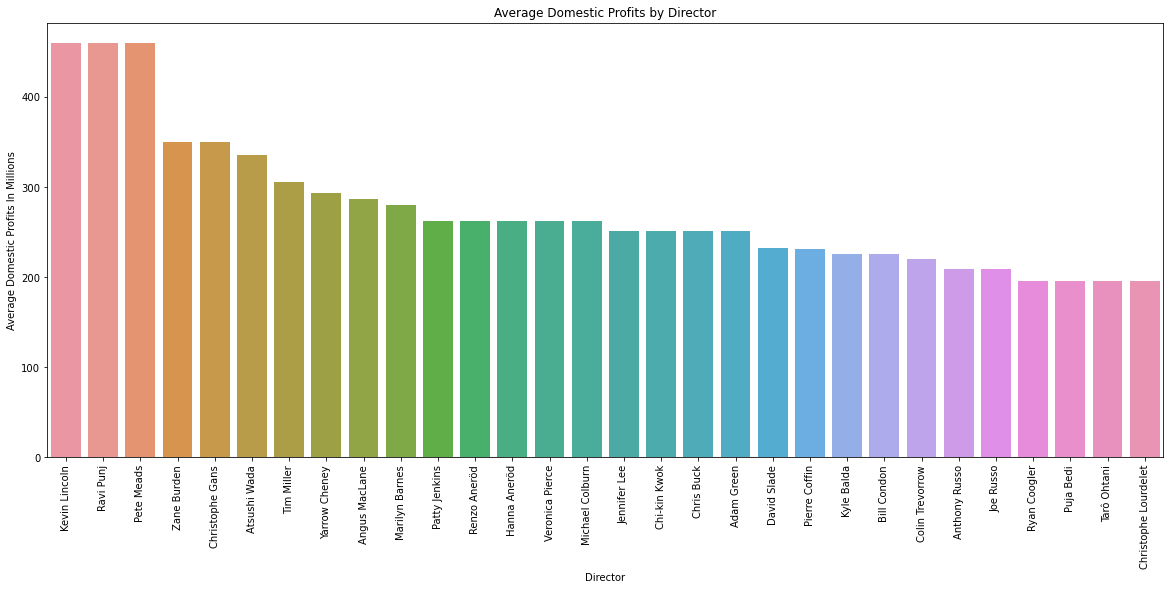

In [31]:
plt.figure(figsize=(20,8))
w=sns.barplot(data=directors_d_top, x="primary_name", y="domesticprofits_inmillions", ci=None)
w.set(xlabel='Director',
       ylabel='Average Domestic Profits In Millions',
       title='Average Domestic Profits by Director')
plt.xticks(rotation=90)

plt.show()